# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Group Project: Alzheimer’s Disease and Cognitive Impairment Prediction


**Group 86**<br/>
**Group Member**: Yawen Gao, Weiyu Yao, Yue Li

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import display


<div class='theme'> Data Cleaning & Preliminary EDA </div>

In this part, a data cleaning process and a correlation matrix between all potential variables is included. 


<div class='exercise'><b> 1. Data cleaning (Step 1)</b></div>

First we need to clean the data and make every variable and values ready for the Preliminary EDA. Below are the steps that are followed.
- read in data
- drop columns that are not related to model.
- convert all temporary variables into datetime type
- Turn all values of categorical variables into categories named in 0, 1, 2, 3...while keeping NaN and turining all 'Unknown's to NaN 

After these steps, we are ready to create the correlation matrix in Preliminary EDA. 

In [3]:
# read in data
df = pd.read_csv('data/ADNI_TF/ADNIMERGE.csv')
df.head()

,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,...,NaN,NaN,1.36926,NaN,NaN,0.000000,0.00000,0,0,2017-08-13 23:50:48.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,...,NaN,NaN,1.09079,NaN,NaN,0.000000,0.00000,0,0,2017-08-13 23:50:48.0
2,3,011_S_0003,m06,11,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,...,NaN,NaN,1.09079,NaN,NaN,0.498289,5.96721,6,6,2017-08-13 23:50:48.0
3,3,011_S_0003,m12,11,ADNI1,ADNI1,2006-09-12,AD,81.3,Male,...,NaN,NaN,1.09079,NaN,NaN,0.999316,11.96720,12,12,2017-08-13 23:50:48.0
4,3,011_S_0003,m24,11,ADNI1,ADNI1,2007-09-12,AD,81.3,Male,...,NaN,NaN,1.09079,NaN,NaN,1.998630,23.93440,24,24,2017-08-13 23:50:48.0


In [4]:
#drop columns that are not related to model
bad = ['PTID','VISCODE','SITE','COLPROT','ORIGPROT']
df1 = df.drop(bad, axis = 1)

#change 'EXAMDATE', 'EXAMDATE_bl' &'update_stamp' to datetime type
df1['EXAMDATE'] = pd.to_datetime(df['EXAMDATE'])
df1['EXAMDATE_bl'] = pd.to_datetime(df['EXAMDATE_bl'])
df1['update_stamp'] = pd.to_datetime(df['update_stamp'])
df1.head()

,RID,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,...,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married,0.0,...,NaN,NaN,1.36926,NaN,NaN,0.000000,0.00000,0,0,2017-08-13 23:50:48
1,3,2005-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,...,NaN,NaN,1.09079,NaN,NaN,0.000000,0.00000,0,0,2017-08-13 23:50:48
2,3,2006-03-13,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,...,NaN,NaN,1.09079,NaN,NaN,0.498289,5.96721,6,6,2017-08-13 23:50:48
3,3,2006-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,...,NaN,NaN,1.09079,NaN,NaN,0.999316,11.96720,12,12,2017-08-13 23:50:48
4,3,2007-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,...,NaN,NaN,1.09079,NaN,NaN,1.998630,23.93440,24,24,2017-08-13 23:50:48


In [5]:
#Turn all values of categorical variables into categories named in 0, 1, 2, 3...while keeping NaN and turining all 'Unknown's to NaN
df2 = df1.copy()
cat = [] #list of names of categorical variables
catdict_raw = {} #dictionary with names of categorical variables as keys, and all categories as values, including nan & 'Unknown'
catdict = {} #dictionary with names of categorical variables as keys, and non-nan categories as values (excluding nan & 'Unknown')
for v in df2.columns:
    if df2[v].dtypes == 'O':
        cat.append(v)
        catdict_raw[v] = list(set(df2[v]))
        df2[v].fillna('Unknown', inplace = True) #replace all NaN first into 'Unknown'
        catdict[v] = list(set(df2[v]))
        if 'Unknown' in catdict[v]:
            catdict[v].remove('Unknown') #'Unknown' should not participate in categorizing
        for i in range(len(catdict[v])):
            df2[v].replace(catdict[v][i], i, inplace = True) #Turn all values of categorical variables into categories named in 0, 1, 2, 3...
        df2[v] = pd.to_numeric(df2[v], errors = 'coerce') #convert all 'Unknown's then to NaN
print(cat)
print(catdict_raw)
print(catdict)
df2

['DX_bl', 'PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'FLDSTRENG', 'FSVERSION', 'DX', 'FLDSTRENG_bl', 'FSVERSION_bl']
{'DX_bl': ['AD', nan, 'CN', 'LMCI', 'EMCI', 'SMC'], 'PTGENDER': ['Male', 'Female'], 'PTETHCAT': ['Not Hisp/Latino', 'Hisp/Latino', 'Unknown'], 'PTRACCAT': ['More than one', 'Black', 'Am Indian/Alaskan', 'Asian', 'Hawaiian/Other PI', 'White', 'Unknown'], 'PTMARRY': ['Never married', 'Divorced', 'Widowed', 'Married', 'Unknown'], 'FLDSTRENG': [nan, '1.5 Tesla MRI', '3 Tesla MRI'], 'FSVERSION': [nan, 'Cross-Sectional FreeSurfer (FreeSurfer Version 4.3)', 'Cross-Sectional FreeSurfer (5.1)'], 'DX': [nan, 'Dementia', 'CN', 'MCI'], 'FLDSTRENG_bl': [nan, '1.5 Tesla MRI', '3 Tesla MRI'], 'FSVERSION_bl': [nan, 'Cross-Sectional FreeSurfer (FreeSurfer Version 4.3)', 'Cross-Sectional FreeSurfer (5.1)']}
{'DX_bl': ['AD', 'CN', 'LMCI', 'EMCI', 'SMC'], 'PTGENDER': ['Male', 'Female'], 'PTETHCAT': ['Not Hisp/Latino', 'Hisp/Latino'], 'PTRACCAT': ['More than one', 'Black', 'Am Indian/Ala

,RID,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,...,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,2005-09-08,1.0,74.3,0,16,0.0,5.0,3.0,0.0,...,NaN,NaN,1.36926,NaN,NaN,0.000000,0.00000,0,0,2017-08-13 23:50:48
1,3,2005-09-12,0.0,81.3,0,18,0.0,5.0,3.0,1.0,...,NaN,NaN,1.09079,NaN,NaN,0.000000,0.00000,0,0,2017-08-13 23:50:48
2,3,2006-03-13,0.0,81.3,0,18,0.0,5.0,3.0,1.0,...,NaN,NaN,1.09079,NaN,NaN,0.498289,5.96721,6,6,2017-08-13 23:50:48
3,3,2006-09-12,0.0,81.3,0,18,0.0,5.0,3.0,1.0,...,NaN,NaN,1.09079,NaN,NaN,0.999316,11.96720,12,12,2017-08-13 23:50:48
4,3,2007-09-12,0.0,81.3,0,18,0.0,5.0,3.0,1.0,...,NaN,NaN,1.09079,NaN,NaN,1.998630,23.93440,24,24,2017-08-13 23:50:48
5,4,2005-11-08,2.0,67.5,0,10,1.0,5.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0,0,2017-08-13 23:50:48
6,4,2006-05-02,2.0,67.5,0,10,1.0,5.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.479124,5.73770,6,6,2017-08-13 23:50:48
7,4,2006-11-14,2.0,67.5,0,10,1.0,5.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1.015740,12.16390,12,12,2017-08-13 23:50:48
8,4,2007-05-14,2.0,67.5,0,10,1.0,5.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,1.511290,18.09840,18,18,2017-08-13 23:50:48
9,4,2008-11-18,2.0,67.5,0,10,1.0,5.0,3.0,0.0,...,NaN,NaN,NaN,NaN,NaN,3.028060,36.26230,36,36,2017-08-13 23:50:48


<div class='exercise'> <b> 2. Preliminary EDA </b> </div>

We want to draw the correlation matrix, which needs the correlation value for each two pair of variables. In this case, it is better if we not treat NaN (like assigning NaN with random values or mean values) because the loss of data is small when doing correlation analysis, the probability of two variables either has a NaN is small, so we just delete any pair that either variable has a NaN. So, in correlation analysis, it is better to keep all the NaNs. 

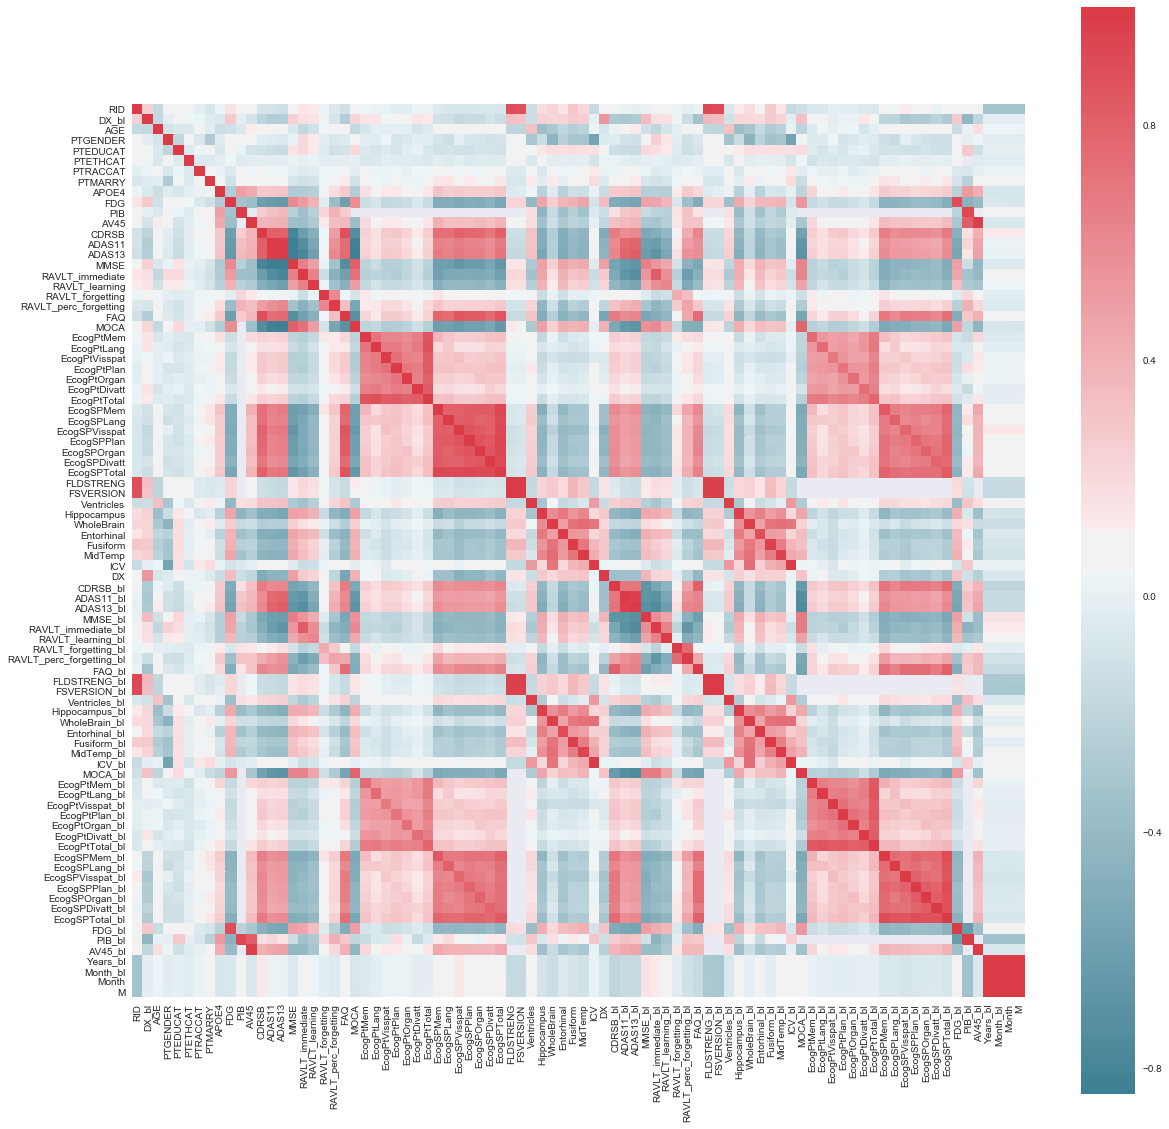

In [6]:
import seaborn as sns
f, ax = plt.subplots(figsize=(20,20))
corr = df2.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

<div class='exercise'> <b> 3. Data Cleaning (Step 2) for Regression </b> </div>

However, when doing regression models, it is necessay to get rid of all the NaNs. So in this section we will carry on data cleaning for all the original NaNs and 'Unknown' values. 